In [5]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
# load vic parameter file
vic_param = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_params_Modis_calibrated_Indus.nc')
# print out the variable names
print(f'vic_parameter file has following variables: \n {vic_param.variables.keys()}\n')
domain = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/domain_Indus.nc') #load mask file
mask = np.flip(domain.variables['mask'][:],axis = 0).mask # 

vic_parameter file has following variables: 
 dict_keys(['AreaFract', 'Nelev', 'Pfactor', 'elev', 'elevation', 'lat', 'lon', 'snow_band', 'Ds', 'Dsmax', 'Ws', 'c', 'infilt', 'annual_prec', 'avg_T', 'run_cell', 'Cv', 'LAI', 'Nveg', 'RGL', 'albedo', 'displacement', 'fcanopy', 'month', 'overstory', 'rad_atten', 'rarc', 'rmin', 'root_depth', 'root_fract', 'root_zone', 'trunk_ratio', 'veg_class', 'veg_rough', 'wind_atten', 'wind_h', 'b_co2', 'Ksat', 'Nlayer', 'Wcr_FRACT', 'Wfc_FRACT', 'Wpwp_FRACT', 'bubble', 'bulk_density', 'depth', 'dp', 'expt', 'fs_active', 'init_moist', 'phi_s', 'quartz', 'resid_moist', 'rough', 'snow_rough', 'soil_density'])



plot the Ksat to check what area might have capillary rise

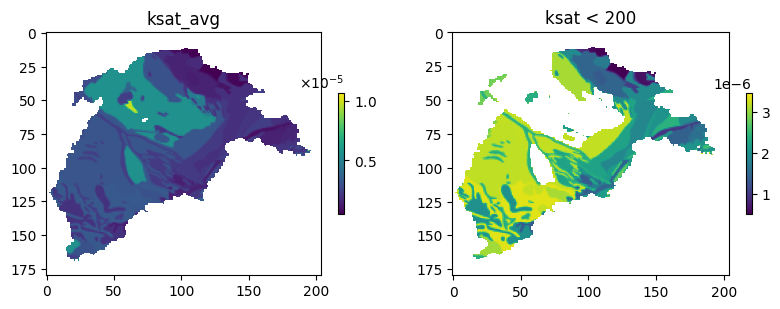

In [4]:
# load the ksat parameter
ksat = vic_param.variables['Ksat'][:]
# split the ksat into 3 layers and do unit conversion from mm/day to m/s

ksat_layer1 = ksat[0, :, :] / (1000 * 24 * 3600)
ksat_layer2 = ksat[1, :, :] / (1000 * 24 * 3600)
ksat_layer3 = ksat[2, :, :] / (1000 * 24 * 3600)
# do an average of the 3 layers
ksat_avg =( (ksat_layer1 + ksat_layer2 + ksat_layer3) / 3).data
ksat_avg[mask] = np.nan
ksat200 = ksat_avg.copy()
ksat200[ksat200 > 300/1000/24/3600] = np.nan

#subplots ksat_avg, ksat200
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].imshow(ksat_avg)
ax[0].set_title('ksat_avg')
fig.colorbar(ax[0].imshow(ksat_avg), ax=ax[0], orientation='vertical',  format=ticker.ScalarFormatter(useMathText=True),shrink=0.5  )

ax[1].imshow(ksat200)
ax[1].set_title('ksat < 200')
import matplotlib.ticker as ticker

fig.colorbar(ax[1].imshow(ksat200), ax=ax[1], orientation='vertical', fraction=.1, format=ticker.ScalarFormatter(useMathText=False),shrink=0.5   )

plt.tight_layout()
plt.show()




<class 'numpy.ndarray'>


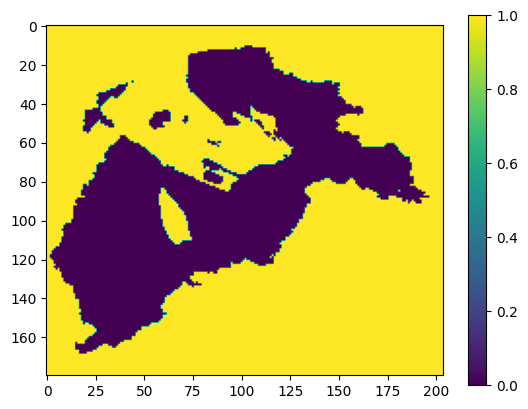

In [5]:
# create a maskarray from ksat200
ksat200_mask = np.ma.masked_array(ksat200, mask=np.isnan(ksat200)).mask
plt.imshow(ksat200_mask)
plt.colorbar()
print(type(ksat200_mask))

calculate the effective porosity n = bulk_density/soil_density


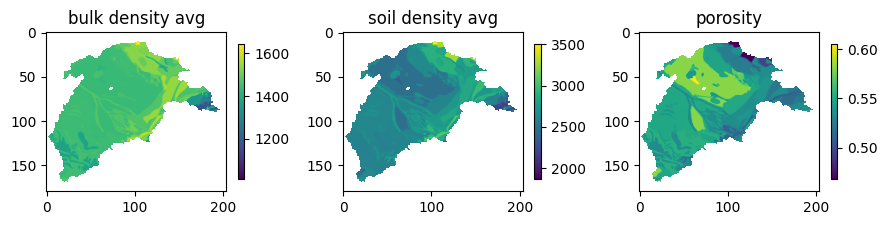

In [24]:
bulk_density = vic_param.variables['bulk_density']
bulk_density=np.flip(bulk_density,axis=0)
bulk_density1 = bulk_density[0, :, :]
bulk_density2 = bulk_density[1, :, :]
bulk_density3 = bulk_density[2, :, :]
bulk_density_avg = ((bulk_density1 + bulk_density2 + bulk_density3) / 3).data
bulk_density_avg[mask] = np.nan

soil_density = vic_param.variables['soil_density']
soil_density1 = soil_density[0, :, :]
soil_density2 = soil_density[1, :, :]
soil_density3 = soil_density[2, :, :]
soil_density_avg = ((soil_density1 + soil_density2 + soil_density3) / 3).data

soil_density_avg[mask] = np.nan
porosity = bulk_density_avg / soil_density_avg
porosity1 = bulk_density1 / soil_density1
porosity2 = bulk_density2 / soil_density2
porosity3 = bulk_density3 / soil_density3



fig, ax = plt.subplots(1, 3, figsize=(9, 3))
im0 = ax[0].imshow(bulk_density_avg)
ax[0].set_title('bulk density avg')
fig.colorbar(im0, ax=ax[0],shrink=0.5)

im1 = ax[1].imshow(soil_density_avg)
ax[1].set_title('soil density avg')
fig.colorbar(im1, ax=ax[1],shrink=0.5)

im2 = ax[2].imshow(porosity)
ax[2].set_title('porosity')
fig.colorbar(im2, ax=ax[2],shrink=0.5)

plt.tight_layout()
plt.show()

In [40]:
#calculate max_moist as pososity * depth

print(bulk_density.shape)

porosity_3 = bulk_density / soil_density



depth = vic_param.variables['depth'][:, :, :]
max_moist = porosity_3 * depth *1000

print(max_moist.shape)

max_moist[0][mask] = np.nan
max_moist[1][mask] = np.nan
max_moist[2][mask] = np.nan




(3, 180, 204)
(3, 180, 204)


In [39]:
max_moist = np.flip(max_moist,axis=1)
porosity = np.flip(porosity,axis=1)


#open parameter file and write max_moist and porosity to it
with nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_derived_param_for_coupling.nc','a') as ds:
    #create a new dimension layer
    #ds.createDimension('lay', 3)
    #create a new variable
    #ds.createVariable('max_moist', 'f4', ('lay', 'lat', 'lon',))
    #ds.createVariable('porosity', 'f4', ('lay', 'lat', 'lon',))
    #write 3 layser max_moist to the file
    ds.variables['max_moist'][:] = max_moist
    ds.variables['porosity'][:] = porosity
    

ValueError: could not broadcast input array from shape (180,204) into shape (36720,)

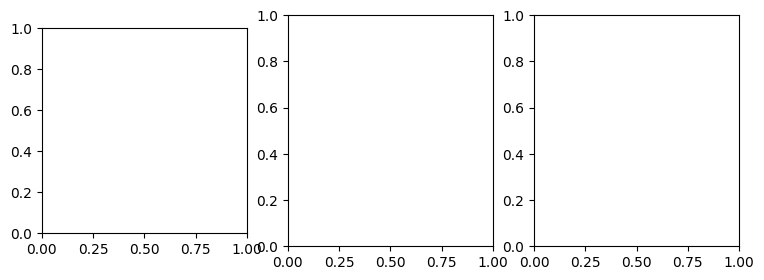

In [38]:


fig, ax = plt.subplots(1, 3, figsize=(9, 3))
im0 = ax[0].imshow(max_moist[0])
ax[0].set_title('max_moist')
fig.colorbar(im0, ax=ax[0],shrink=0.5)

im1 = ax[1].imshow(max_moist[1])
ax[1].set_title('max_moist')
fig.colorbar(im1, ax=ax[1],shrink=0.5)

im2 = ax[2].imshow(max_moist[2])
ax[2].set_title('max_moist')
fig.colorbar(im2, ax=ax[2],shrink=0.5)

plt.tight_layout()
plt.show()






CPsurface has 15167 non-nan values
max depth is 2.536641397169828
min depth is 2.0184067477595584
max CPsurface is 6162.756475754599
min CPsurface is -2.0660883658684575
<class 'numpy.ma.core.MaskedArray'>


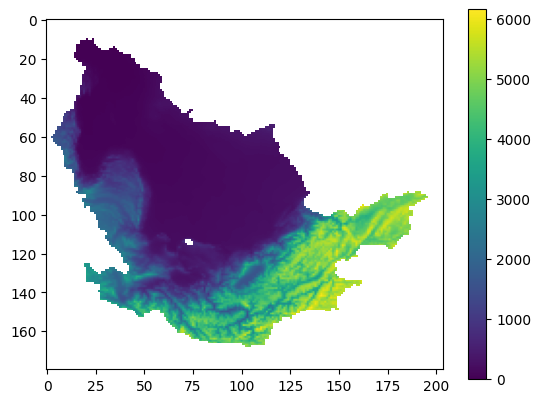

In [6]:
import netCDF4 as nc
import os
surface = vic_param.variables['elev'][:]
surface = np.flip(surface,axis=0)
surface[mask] = np.nan


depth = vic_param.variables['depth'][2, :, :]
depth = np.flip(depth,axis=0)
depth[mask] = np.nan
CPsurface = surface - depth
CPsurface = np.flip(CPsurface,axis = 0)

plt.imshow(CPsurface)
print(f'CPsurface has {np.count_nonzero(~np.isnan(CPsurface))} non-nan values')
print(f'max depth is {np.nanmax(depth)}')
print(f'min depth is {np.nanmin(depth)}')
print(f'max CPsurface is {np.nanmax(CPsurface)}')
print(f'min CPsurface is {np.nanmin(CPsurface)}')
plt.colorbar()
print(type(CPsurface))





estimate hc


min hc is 1.5063829003760536 m
max hc is 5.410660576344763 m


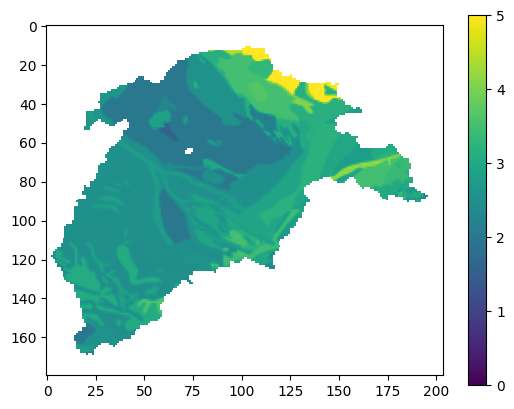

In [7]:
import numpy as np
sigma = (0.0742+0.0728)/2 # suface tension of water at 15 degree C
g = 9.81 # gravity
rho = 999.06 # density of water at 15 degree C
eta = 1.1375*0.001 # viscosity of water at 15 degree C
ha = 0.25 # average air entry suction head
hc = sigma * porosity / np.sqrt(2 * eta * rho * g * ksat_avg) * 0.5 + (1 - porosity) * ha
plt.imshow(hc,vmin = 0, vmax = 5)
plt.colorbar()
#setup min and max for colorbar
hcmin = np.nanmin(hc)
hcmax = np.nanmax(hc)
print(f'min hc is {hcmin} m')
print(f'max hc is {hcmax} m')

#print(sigma/np.sqrt(2 * eta * rho * g ))
from math import cos
from math import pi

sigma = 0.0728
g = 9.81
rho = 998.2
eta = 1.0016*0.001
#print(sigma/np.sqrt(2 * eta * rho * g ))
#print((sigma*0.408*cos(53.3*pi/180)  / np.sqrt(2 * eta * rho * g*0.15))+(1-0.408)*0.15)
#print((0.0164*0.408*cos(53.3*pi/180)  / np.sqrt(0.15))+(1-0.408)*0.15)


according to Malik 1989    
now we estimate the max capillary flux


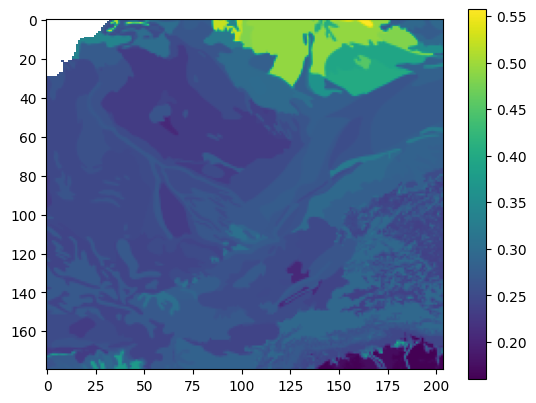

In [9]:
theta_wp = vic_param.variables['Wpwp_FRACT'][:]
plt.imshow(theta_wp[0,:,:])
plt.colorbar()


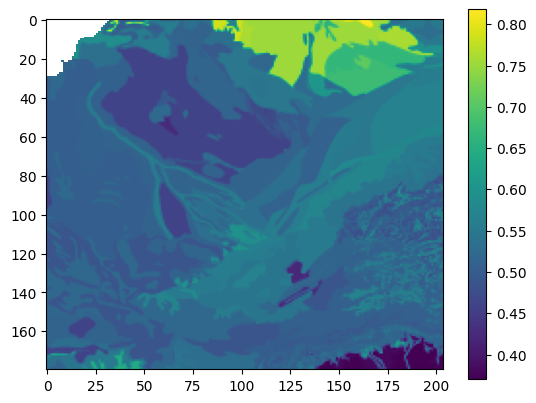

In [10]:
theta_fc = vic_param.variables['Wfc_FRACT'][:]
plt.imshow(theta_fc[0,:,:])
plt.colorbar()

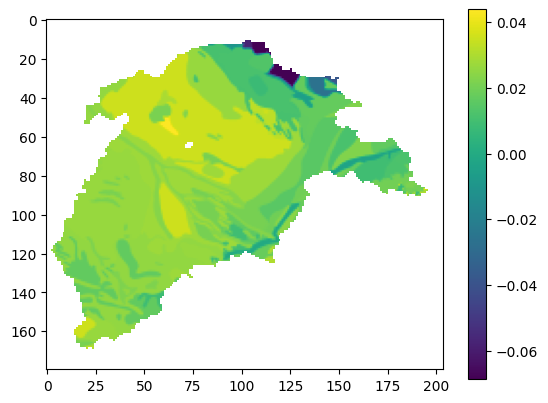

In [11]:
import math
ksatmd = ksat_avg * 24 * 3600 #m/day
b = 0.1068 + 6.547 * 10**(-8) *  ksatmd - 0.31 * theta_wp[2]  #m/d

plt.imshow(b)
plt.colorbar()

inf


/tmp/ipykernel_3129295/3281459572.py:3: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(10197)


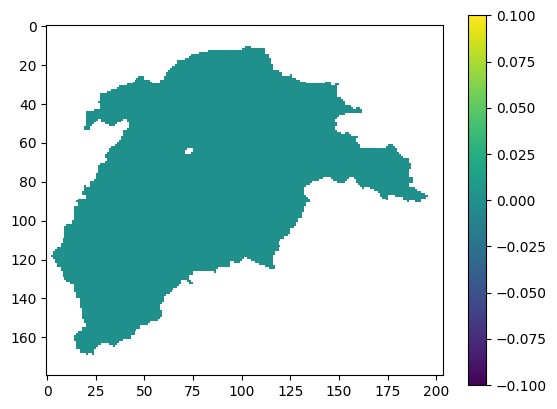

In [18]:
A  = ksatmd *10**-6 * np.exp(5.636+1.326*(10**-6)*ksatmd-0.31*theta_wp[2]) 

denominator = np.exp(10197)
a = A / denominator
print(denominator)

plt.imshow(a)
plt.colorbar()

flux has 15167 non-nan values
max flux is 0.00022746674312864462
min flux is 1.344790691807501e-05
mean flux is 6.558935101730326e-05


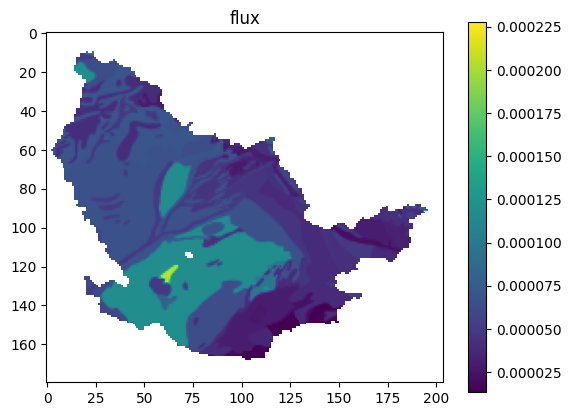

In [19]:
flux = A * np.exp(-b * hc)
flux = np.flip(flux,axis = 0)

#flux = np.ma.masked_array(flux, mask=ksat200_mask)
plt.imshow(flux)
plt.title('flux')
plt.colorbar()
print(f'flux has {np.count_nonzero(~np.isnan(flux))} non-nan values')
print(f'max flux is {np.nanmax(flux)}')
print(f'min flux is {np.nanmin(flux)}')
print(f'mean flux is {np.nanmean(flux)}')


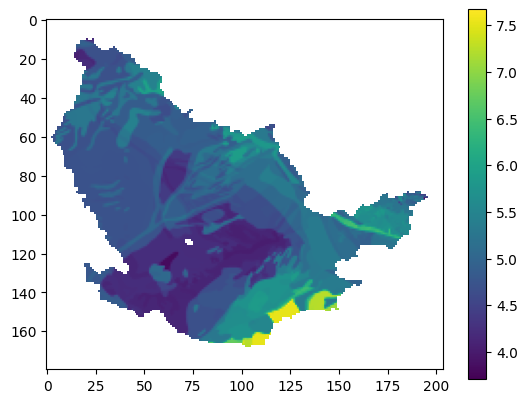

In [26]:



distinction = depth + hc
distinction_masked = np.ma.masked_array(distinction, mask=np.isnan(distinction))

mask = np.flip(domain.variables['mask'][:], axis=0).mask
distinction_masked = np.ma.masked_array(distinction, mask=mask)

distinction= np.flip(distinction_masked, axis = 0)
plt.imshow(distinction)

plt.colorbar()

In [27]:
import numpy as np
flux.shape
nan_array = np.zeros_like(flux)
nan_array[~np.isnan(flux)] = 0.0001
nan_array


masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=9.969209968386869e+36)

In [28]:


import shutil
indus_file_path = '/lustre/nobackup/WUR/ESG/yuan018/99Unuse/domain_Indus.nc'
forcinginputdir ='/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfinput' 
output_file = os.path.join(forcinginputdir, "CPsurface.nc")
shutil.copy(indus_file_path, output_file)

with nc.Dataset(output_file,'a') as ncfile:
    CPsurface_var  = ncfile.createVariable('cpsurface','f4',('lat','lon'))
    CPsurface_var.unit = 'meters'
    CPsurface_var.standard_name = 'capillary rise surface'
    CPsurface_var.long_name = 'capillary rise suface elevation (m), namely the bottom of the VIC soil layer'
    CPsurface_var[:,:] = CPsurface
    Max_rate_var = ncfile.createVariable('max_capillary_flux','f4',('lat','lon'))
    Max_rate_var.unit = 'meters'
    Max_rate_var.standard_name = 'max_capillary_flux'
    Max_rate_var.long_name = 'maximum capillary flux derived from the max capillary height (m/d)'
    Max_rate_var[:,:] = nan_array
    distinction_var = ncfile.createVariable('distinction_depth','f4',('lat','lon'))
    distinction_var.unit = 'meters'
    distinction_var.standard_name = 'distinction depth'
    distinction_var.long_name = 'distinction depth when capillary rise = 0 (m)'
    distinction_var[:,:] = distinction


## test of adding the capillary rise package in the  modflow simulation
### let's first try the steady state


In [11]:
os.chdir('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python')
import os 
import sys
sys.path.append('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python')
import flopy
import numpy as np
import xarray as xr
import netCDF4 as nc
import subprocess  # for calling shell commands
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
import vic_runner as vr
import support_function as sf
from config_module import config_indus_ubuntu
from osgeo import gdal
from netCDF4 import Dataset, date2num
from matplotlib import pyplot as plt
import mf_run as mf
import shutil


%env LD_LIBRARY_PATH=/shared/legacyapps/netcdf/gcc/64/4.6.1/lib:$LD_LIBRARY_PATH   
#%%
cwd = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/'
config_indus_ubuntu.paths.set_template_dir(os.path.join(cwd, 'python', 'VIC_config_file_naturalized_template_pyread_anunna.txt'))
config_indus_ubuntu.paths.set_statefile_dir(os.path.join(cwd, 'python', 'statefile'))
config_indus_ubuntu.paths.set_configfile_dir(os.path.join(cwd, 'python', 'configfile'))
config_indus_ubuntu.paths.set_vic_executable('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/99vic_offline_src/drivers/image/vic_image_gwm.exe')
config_indus_ubuntu.set_startstamp(datetime(1968, 1, 1))
config_indus_ubuntu.paths.set_mfinput_dir('/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/')
config_indus_ubuntu.paths.set_mfoutput_dir('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfoutput/workspace/')
config_indus_ubuntu.set_humanimpact(False)


env: LD_LIBRARY_PATH=/shared/legacyapps/netcdf/gcc/64/4.6.1/lib:$LD_LIBRARY_PATH


Warning 1: dimension #1 (lon) is not a Longitude/X dimension.
Warning 1: dimension #0 (lat) is not a Latitude/Y dimension.


[[(0, 11, 102), 5147.8794, 2.355759, 7.2328925], [(0, 11, 103), 4970.4766, 2.355759, 7.2291093], [(0, 11, 104), 4889.3945, 2.355759, 7.2385874], [(0, 11, 105), 5010.4546, 2.4098911, 7.3523135], [(0, 12, 97), 5117.744, 2.4981105, 7.111861], [(0, 12, 100), 4985.6426, 2.5615065, 7.4723663], [(0, 12, 101), 4787.969, 2.355759, 7.2409816], [(0, 12, 102), 5189.2793, 2.355759, 7.2409816], [(0, 12, 103), 5067.5347, 2.355759, 7.2409816], [(0, 12, 104), 4661.211, 2.355759, 7.2409816], [(0, 12, 105), 4789.653, 2.4007027, 7.339924], [(0, 12, 106), 5051.4185, 2.4831963, 7.521652], [(0, 12, 107), 4963.227, 2.4831963, 7.5210285], [(0, 12, 108), 4795.498, 2.4831963, 7.521652], [(0, 12, 109), 5076.0356, 2.4831963, 7.521652], [(0, 12, 110), 4965.577, 2.4831963, 7.521652], [(0, 12, 111), 4994.949, 2.4831963, 7.515665], [(0, 12, 112), 5218.3706, 2.4831963, 7.50332], [(0, 13, 83), 5038.941, 2.1441348, 6.3011537], [(0, 13, 84), 4842.0283, 2.2973924, 6.633308], [(0, 13, 85), 4569.619, 2.2657537, 6.5643673], [

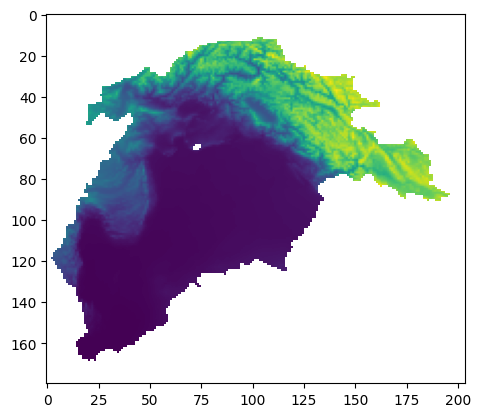

In [13]:
cpr = nc.Dataset('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfinput/CPsurface.nc')
CPsurface = np.flip(cpr.variables['cpsurface'][:].data,axis = 0)
CPrate = np.flip(cpr.variables['max_capillary_flux'][:].data,axis = 0)
CPdistinct = np.flip(cpr.variables['distinction_depth'][:].data,axis = 0)
CPRstress_period_data = []
nrow,ncol = CPsurface.shape
cellids = [(0,i,j) for i in range(nrow) for j in range(ncol)]
for cellid,surface,rate,distinction in zip(cellids,CPsurface.flatten(),CPrate.flatten(),CPdistinct.flatten()):
    cellid_1, cellid_2, cellid_3 = cellid
    if np.isnan(surface) or np.isnan(rate) or np.isnan(distinction):
        continue
    CPRstress_period_data.append([(cellid_1, cellid_2, cellid_3), surface, rate, distinction])
    
print(CPRstress_period_data)
print(len(CPRstress_period_data))

plt.imshow(CPsurface)


-1.0

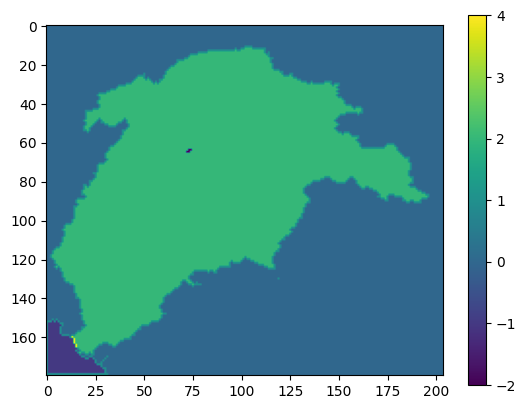

In [17]:
mfinput_dir = '/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/'
nc_boundary = nc.Dataset(mfinput_dir + 'boundary.nc')
bdmask = nc_boundary.variables['idomain'][:].data
plt.imshow(bdmask)
plt.colorbar()
bdmask[166,15]


In [ ]:
path = '/lustre/nobackup/WUR/ESG/yuan018/88Logbook/try_successful_steady_state_1204/Indus_gwl_steady_state.nc'
gwl = nc.Dataset(path)
print(gwl.variables.keys())

dict_keys(['lon', 'lat', 'area', 'mask', 'frac', 'tophead', 'bothead'])


<class 'numpy.ma.core.MaskedArray'>


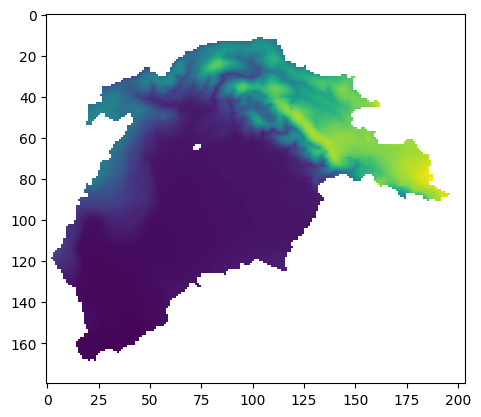

In [ ]:
tophead = gwl.variables['tophead'][:]
tophead = np.flip(tophead,axis=0)
tophead[mask] = np.nan
plt.imshow(tophead)
print(type(tophead))

# water balance analysis


In [12]:
import flopy 
import flopy.utils.binaryfile as bf
import os

# load the ccb file
path = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/mfoutput/workspace/2Ltrans_off_19690101.cbb'
bud = bf.CellBudgetFile(path)
#print(bud.get_unique_record_names())
#print(bud.list_records())
#print(bud._unique_package_names())
#print(bud.get_times())
print(bud.get_indices())
print(bud.get_data(text = 'FLOW-JA-FACE', totim = 31))

None
[array([[[-5.82076609e-11,  1.41885082e+03,  1.34525442e+05, ...,
          0.00000000e+00, -3.13033587e+05, -0.00000000e+00]]])]


In [13]:
bud.get_nrecords

<bound method CellBudgetFile.get_nrecords of <flopy.utils.binaryfile.CellBudgetFile object at 0x1512bb275b50>>

In [14]:
#bud.get_position(5)
bud.get_times()

[31.0]

In [15]:
bud.get_unique_package_names()
bud.get_unique_record_names()

[b'          STO-SS',
 b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'        DATA-SAT',
 b'             RIV',
 b'             RCH',
 b'             EVT',
 b'             CHD']

In [16]:
bud.get_data(text = 'RIV', totim = 31)

[rec.array([( 2551,     1, 0.), ( 2552,     2, 0.), ( 2553,     3, 0.),
            ..., (34293, 14468, 0.), (34294, 14469, 0.),
            (34296, 14470, 0.)],
           dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8')])]

In [17]:
bud.get_data(text = 'RCH', totim = 31)

[rec.array([( 2551,     1, 29.19730418), ( 2552,     2, 29.31445772),
            ( 2553,     3, 48.01824709), ..., (34293, 14474,  0.15377513),
            (34294, 14475,  0.15377576), (34296, 14476,  0.15377119)],
           dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8')])]

In [18]:
bud.get_data(text = 'EVT', totim = 31)

[rec.array([( 2347,     1, 0.), ( 2348,     2, 0.), ( 2349,     3, 0.),
            ..., (34501, 15164, 0.), (34704, 15165, 0.),
            (34909, 15166, 0.)],
           dtype=[('node', '<i4'), ('node2', '<i4'), ('q', '<f8')])]

dict_keys(['lat', 'lon', 'Band1'])


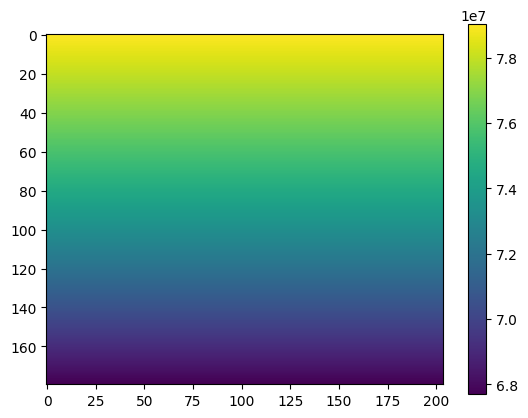

In [19]:
import netCDF4 as nc
import matplotlib.pyplot as plt
file1 = '/lustre/nobackup/WUR/ESG/yuan018/04Input_Indus/Indus_CellArea_m2_05min.nc'
with nc.Dataset(file1, 'r') as ncfile:
    print(ncfile.variables.keys())
    cellarea = ncfile.variables['Band1'][:]
    
plt.imshow(cellarea)
plt.colorbar()

the total cpr is -61596488.475622


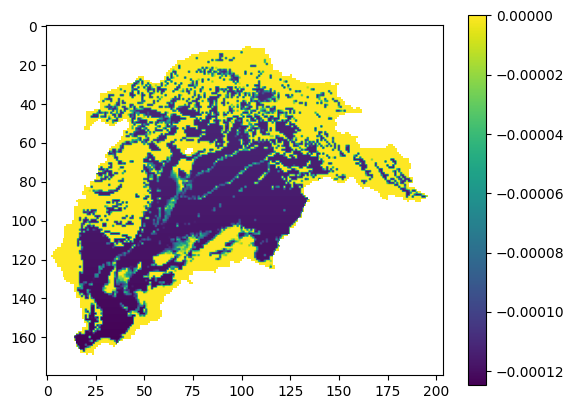

In [20]:
import numpy as np
from matplotlib import pyplot as plt

evt_raw = bud.get_data(text = 'EVT')
evt = [(item['node'],item['q'],item['q']) for item in evt_raw]
ncol, nrow = 204,180
cpr = []
for i in range(len(evt[0][0])):
    idx = evt[0][0][i]
    lay = 0
    row = idx//ncol
    col = idx%ncol-1
    flow = evt[0][2][i]
    rec = [lay,row,col,flow]
    cpr.append(rec)
totalcpr = 0
cpr_array = np.full((nrow, ncol), np.nan)

totalcpr = 0
for item in cpr:
    lay, row, col, flow = item
    totalcpr += flow
    cpr_array[row,col] = flow

cpr_mm = cpr_array/cellarea

# now the unit should be m3/day???? or m3/month
print(f'the total cpr is {totalcpr}')
plt.imshow(cpr_mm)
plt.colorbar()


the total rch is 2533711.2112874966
total net rch is -59062777.2643345


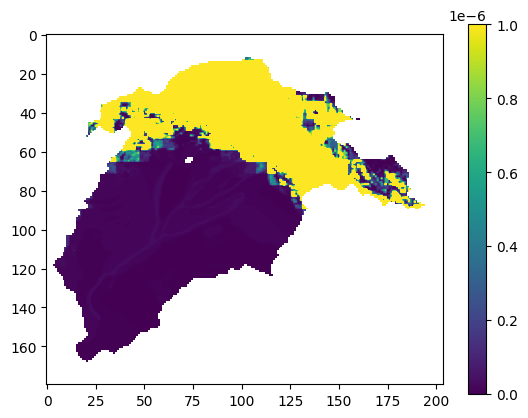

In [11]:
rch_raw = bud.get_data(text = 'RCH', totim = 31)
rch1 =  [(item['node'],item['q'],item['q']) for item in rch_raw]
ncol, nrow = 204,180
rch = []
for i in range(len(rch1[0][0])):
    idx = rch1[0][0][i]
    lay = 0
    row = idx//ncol
    col = idx%ncol-1
    flow = rch1[0][2][i]
    rec = [lay,row,col,flow]
    rch.append(rec)
totalrch = 0
rch_array = np.full((nrow, ncol), np.nan)

totalrch = 0
for item in rch:
    lay, row, col, flow = item
    totalrch += flow
    rch_array[row,col] = flow

rch_mm = rch_array/cellarea
totalnetrch = totalrch+totalcpr
# now the unit should be m3/day???? or m3/month
print(f'the total rch is {totalrch}')
print(f'total net rch is {totalnetrch}')
plt.imshow(rch_mm,vmin = 0, vmax = 0.000001)
plt.colorbar()


# testing script for updating statefile

In [3]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [10]:
param_file = '/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/04Forcing/02HumanImpact/coverage_monthly_MIRCA/coverage_monthly_MIRCA_1968.nc'
max_moist_file = '/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/VIC_derived_param_for_coupling.nc'
#read the parameter file to get the fraction for each veg class
with nc.Dataset(param_file,'r') as param:
    veg_class_fraction = param.variables['coverage'][:]

with nc.Dataset(max_moist_file,'r') as max_moist:
    max_moisture = max_moist.variables['max_moist'][:]

In [11]:
print(veg_class_fraction.shape)
print(max_moisture.shape)

veg_class_fraction = np.flip(veg_class_fraction,axis = 1)
max_moisture = np.flip(max_moisture,axis = 1)

(12, 22, 180, 204)
(3, 180, 204)


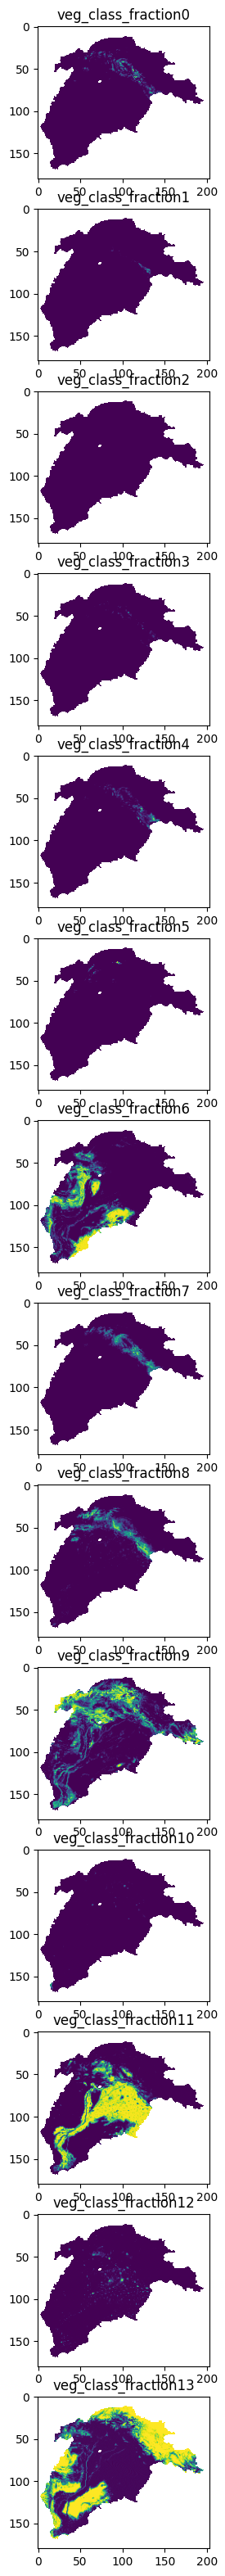

In [7]:
# plot all veg_class_fraction in one subplots
fig, ax = plt.subplots(14,1, figsize=(3,40))


for i in range(14):
    veg_class_fraction[i,:,:][mask] = np.nan
    
    ax[i].imshow(veg_class_fraction[i,:,:])
    ax[i].set_title(f'veg_class_fraction{i}')
plt.show()

        

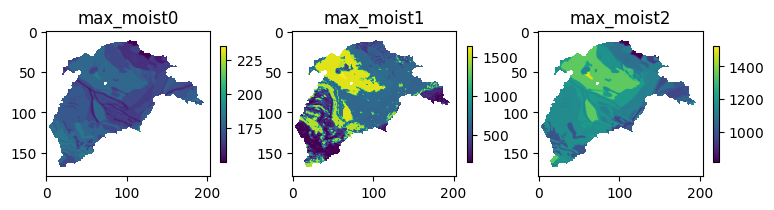

In [10]:
# plot all veg_class_fraction in one subplots
fig1, ax1 = plt.subplots(1,3, figsize=(9,3))
                        
for i in range(3):
    max_moisture[i][mask] = np.nan
    
    ax1[i].imshow(max_moisture[i,:,:])
    ax1[i].set_title(f'max_moist{i}')
    fig1.colorbar(ax1[i].imshow(max_moisture[i,:,:]), ax=ax1[i], orientation='vertical',  format=ticker.ScalarFormatter(useMathText=True),shrink=0.5  )
plt.show()

In [49]:
#prepare a test array for capillary rise flux
cpr_mm_month = cpr_mm * 31
print(cpr_mm_month.shape)
#plt.imshow(cpr_mm_month)
#plt.colorbar()

(180, 204)


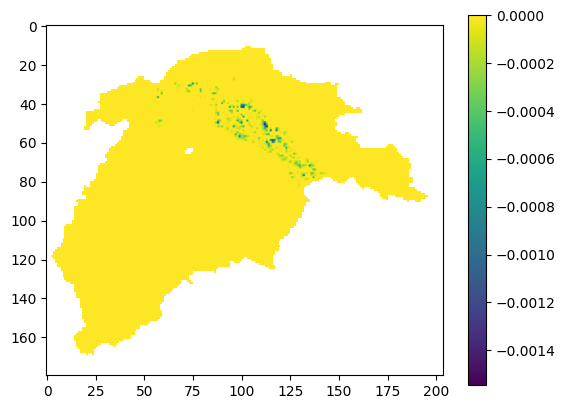

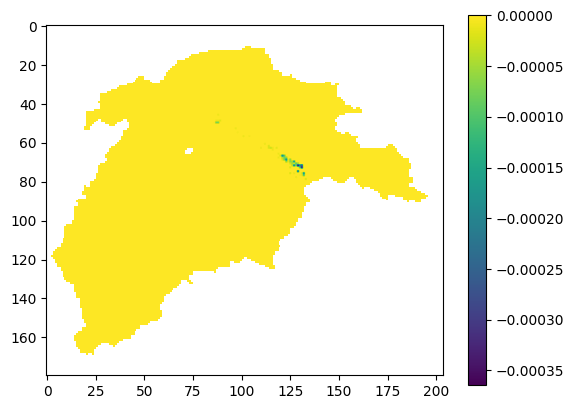

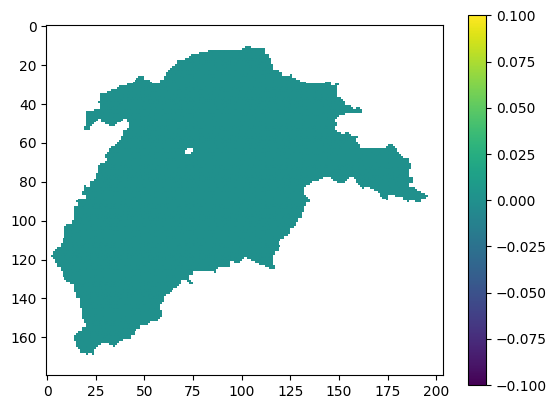

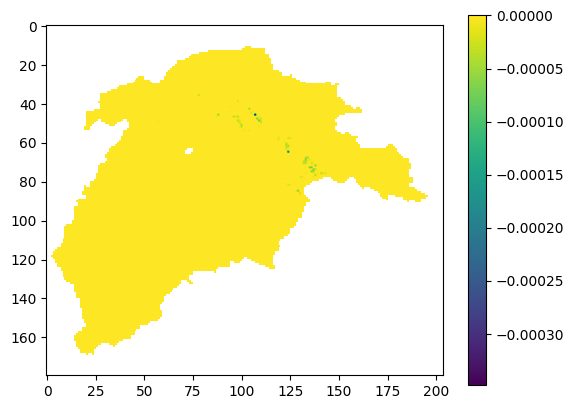

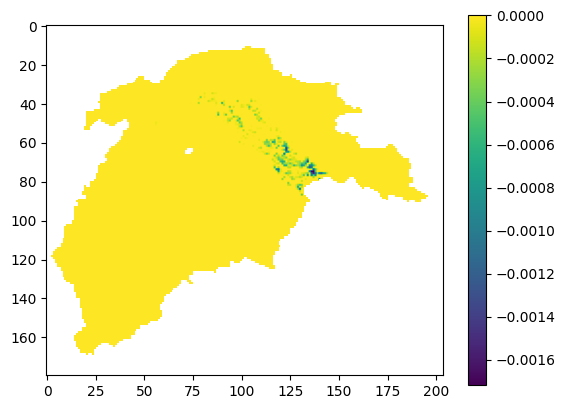

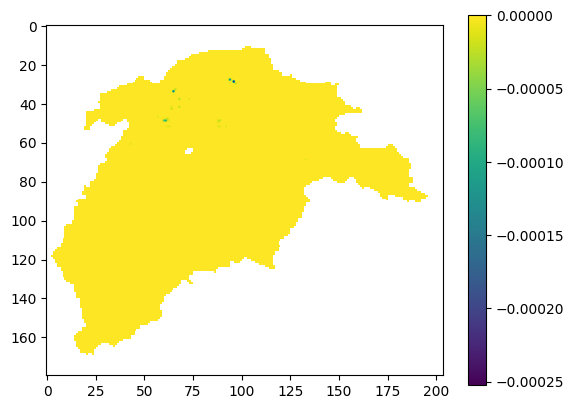

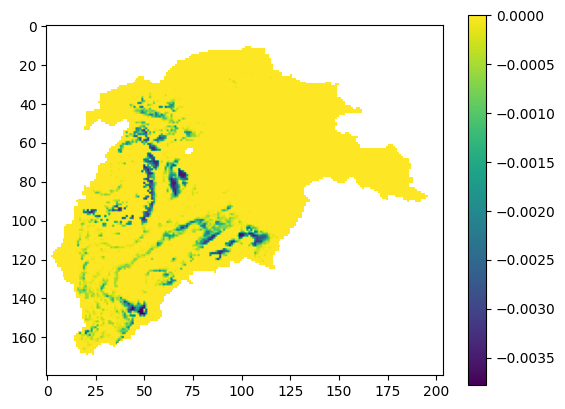

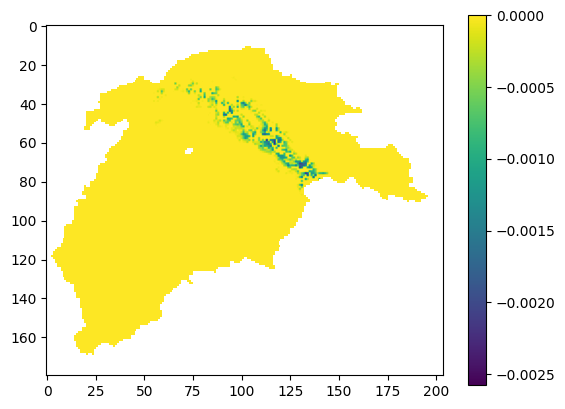

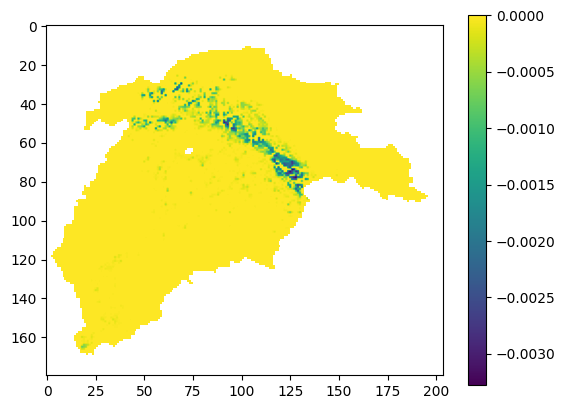

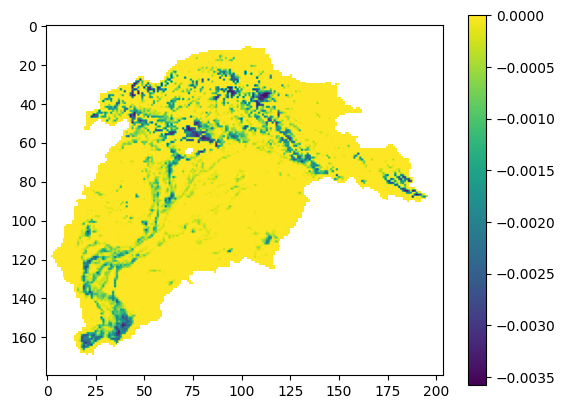

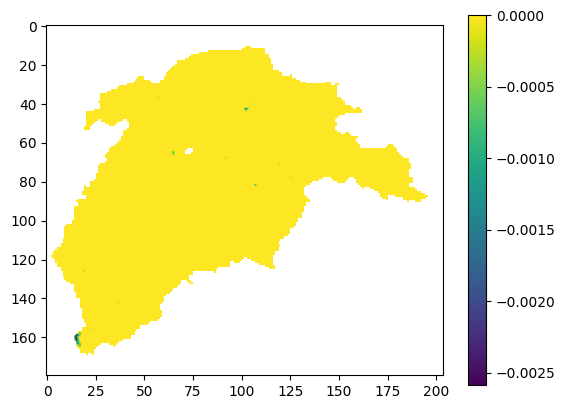

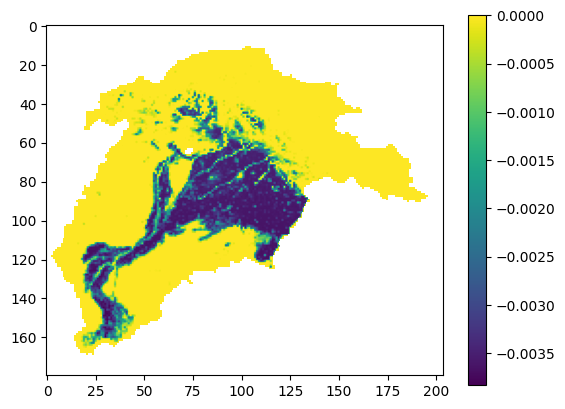

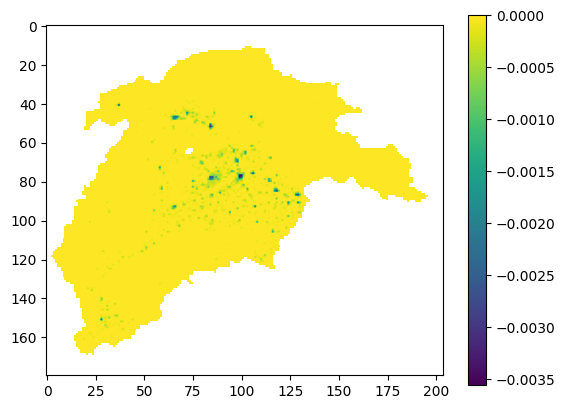

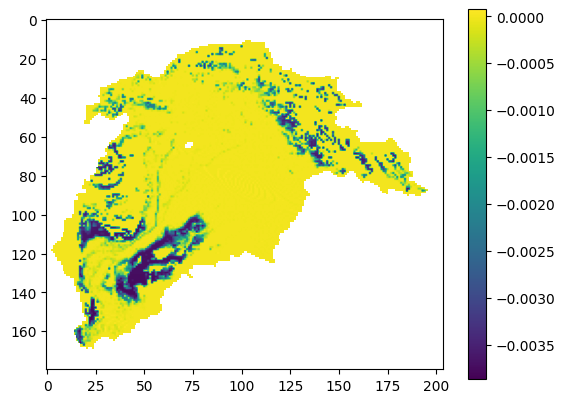

In [50]:
# split the cpr_mm_month into 14 vegtype based on the Cv fraction
cpr_mm_month_vegtype = np.zeros((14,180,204))
for i in range(14):
    cpr_mm_month_vegtype[i,:,:] = cpr_mm_month * veg_class_fraction[i,:,:]
    cpr_mm_month_vegtype[i,:,:][mask] = np.nan
    plt.imshow(cpr_mm_month_vegtype[i,:,:])
    plt.colorbar()
    plt.show()

cpr_mm_month_vegtype = np.flip(cpr_mm_month_vegtype,axis = 1)

In [90]:
# Read the state file
#statefile_dir = config.paths.statefile_dir
state_file = '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/statefile/state_file_.19680201_00000.nc'
stateout = nc.Dataset(state_file, 'r')
# read the 3 soil moisture layers 
soil_moisture = stateout.variables['STATE_SOIL_MOISTURE'][:,:,:,:,:]
print(soil_moisture.shape)
soil_mositure_layer1 = soil_moisture[:,0,0,:,:]
soil_mositure_layer2 = soil_moisture[:,0,1,:,:]
soil_mositure_layer3 = soil_moisture[:,0,2,:,:]
print(soil_mositure_layer1.shape)
print(soil_mositure_layer2.shape)
print(soil_mositure_layer3.shape)

nc.close()


OSError: [Errno -51] NetCDF: Unknown file format: '/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/statefile/state_file_.19680201_00000.nc'

(180, 204)
(180, 204)
(180, 204)


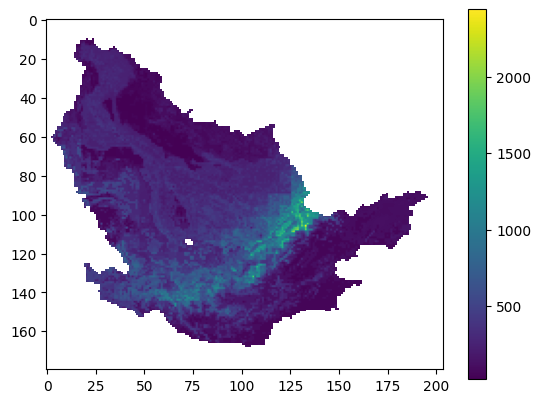

In [89]:
total_soil_moisture_layer1 = np.sum(soil_mositure_layer1,axis = 0)
total_soil_moisture_layer2 = np.sum(soil_mositure_layer2,axis = 0)
total_soil_moisture_layer3 = np.sum(soil_mositure_layer3,axis = 0)
print(total_soil_moisture_layer1.shape)
print(total_soil_moisture_layer2.shape)
print(total_soil_moisture_layer3.shape)
plt.imshow(total_soil_moisture_layer1)
plt.colorbar()

In [42]:
# add cpr_mm_month_vegtype to soil moisture
soil_moisture[:,-1,:,:] = soil_moisture[:,-1,:,:] + cpr_mm_month_vegtype
total_soil_moisture = np.sum(soil_moisture[:,-1,:,:],axis = 0)

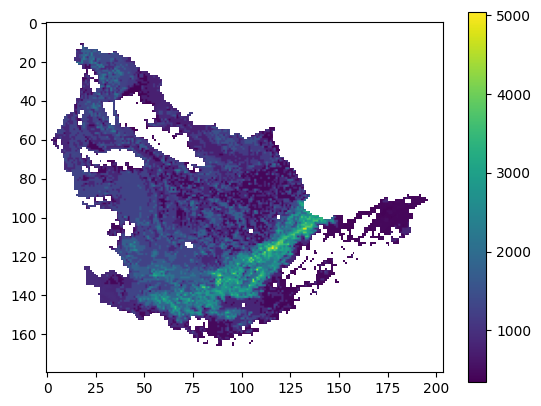

In [45]:
total_soil_moisture.shape
plt.imshow(total_soil_moisture)
plt.colorbar()